In [1]:
import numpy as np
import utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Simulate a system of two Van der Pol oscillators

In [2]:
frequency_multiplier = 20

mu1=5
mu2=5
c1 = 0
c2 = 0
tau1=.2
tau2=tau1*frequency_multiplier

x0 = [0.0, 2.0, 2.0, 0.0]

fast_period_length = 11.45015*tau1
slow_period_length = fast_period_length*frequency_multiplier

num_periods_simulate = 15
sampling_rate_simulate = 2048
t_simulate_full = np.linspace(0, num_periods_simulate*slow_period_length,
                int(num_periods_simulate*sampling_rate_simulate*slow_period_length/fast_period_length))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

vdp_simulation = utils.simulate_coupled_vdp(dt_simulate, t_simulate_full.size, x0=x0, mu1=mu1, mu2=mu2, c1=c1, c2=c2,
                                      tau1=tau1, tau2=tau2)[0]

## Add the activity of the two oscillators together to get a time series of one variable

In [3]:
initial_samples = 2*sampling_rate_simulate
t_simulate = t_simulate_full[:-initial_samples]
vdp_solution = vdp_simulation[:,initial_samples:]
coupled_solution = vdp_solution[0:1] + vdp_solution[2:3]

## Subsample to get training data for the fast model

In [4]:
num_periods_subsample = 5
sampling_rate_subsample = 128

t_max_idx = int(num_periods_subsample*fast_period_length/dt_simulate)+2
spacing = sampling_rate_simulate//sampling_rate_subsample

t_sample = t_simulate[:t_max_idx:spacing]
dt_sample = t_sample[1] - t_sample[0]

training_data_fast = coupled_solution[:,:t_max_idx:spacing]

## Build a HAVOK model of the fast dynamics

In [5]:
time_delay=128
time_delay_spacing=1
rank=50

dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
dmd.fit(training_data_fast, dt_sample)
dmd_reconstruction = dmd.reconstruct(t_simulate, imaginary_evals=True)

## Reconstruct the fast dynamics using the HAVOK model, and subtract from the original data to get a prediction of the slow dynamics

In [6]:
offsets = np.real(dmd.b[dmd.omega[1]==0]*dmd.Phi[:,dmd.omega[1]==0])

dmd_reconstruction_fast = dmd.reconstruct(t_simulate, imaginary_evals=True)-np.sum(offsets)
dmd_slow_dynamics = coupled_solution - dmd_reconstruction_fast

## Show long term predictions of fast and slow dynamics

(0.0, 458.00600000000003, -4.0, 4.0)

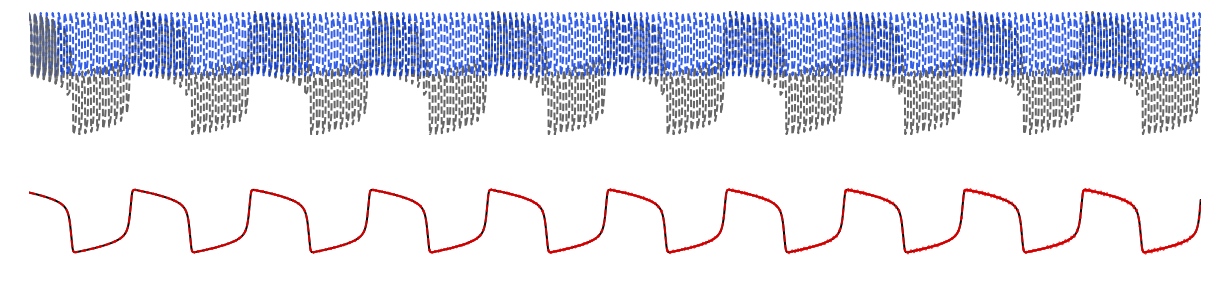

In [7]:
T_display = 10*slow_period_length

plt.figure(figsize=(21,5))

plt.subplot(2,1,1)
plt.plot(t_simulate, coupled_solution[0], '--', linewidth=2, color='#666666') 
plt.plot(t_simulate, dmd_reconstruction[0], '--', alpha=0.8, linewidth=2, color='#0036E2')
plt.plot(t_sample, training_data_fast[0], color='#666666', alpha=0.8, linewidth=2)
plt.xlim([0,T_display])
plt.ylim([-4,4])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(t_simulate, vdp_solution[2], 'k', linewidth=2)
plt.plot(t_simulate, dmd_slow_dynamics[0], 'r--', alpha=0.8, linewidth=2)
plt.xlim([0,T_display])
plt.ylim([-4,4])
plt.axis('off')

## Subsample the prediction of the slow dynamics to get training data for the slow model

In [8]:
t_max_idx_slow = int(num_periods_subsample*slow_period_length/dt_simulate)+2
spacing_slow = frequency_multiplier*spacing

t_sample_slow = t_simulate[:t_max_idx_slow:spacing_slow]
dt_sample_slow = t_sample_slow[1] - t_sample_slow[0]

training_data_slow = dmd_slow_dynamics[:,:t_max_idx_slow:spacing_slow]

## Build a HAVOK model of the slow dynamics

In [9]:
time_delay=128
time_delay_spacing=1
rank=50

dmd = utils.DMD(truncation='hard', threshold=rank, time_delay=time_delay, time_delay_spacing=time_delay_spacing)
dmd.fit(training_data_slow, dt_sample_slow)
dmd_reconstruction_slow = dmd.reconstruct(t_simulate, imaginary_evals=True)

## Look at the long term reconstruction of our coupled system

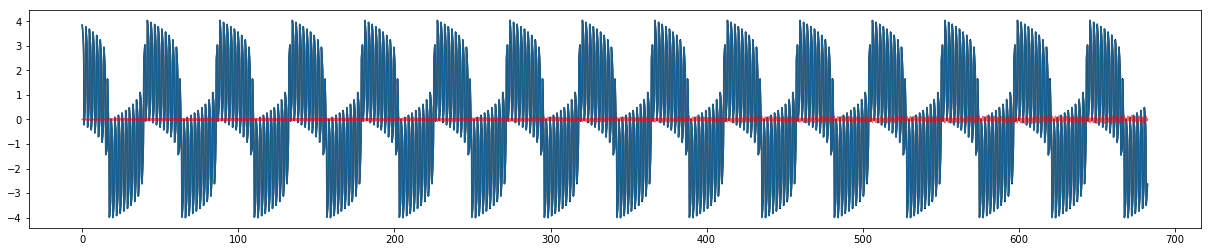

In [10]:
plt.figure(figsize=(21,4))
plt.plot(t_simulate, coupled_solution[0], 'k')
plt.plot(t_simulate, dmd_reconstruction_fast[0] + dmd_reconstruction_slow[0], alpha=0.8)
plt.plot(t_simulate, coupled_solution[0] - (dmd_reconstruction_fast[0] + dmd_reconstruction_slow[0]), 'r', alpha=0.6)

## Plot the fast and slow models

(0.0, 458.00600000000003, -4.0, 4.0)

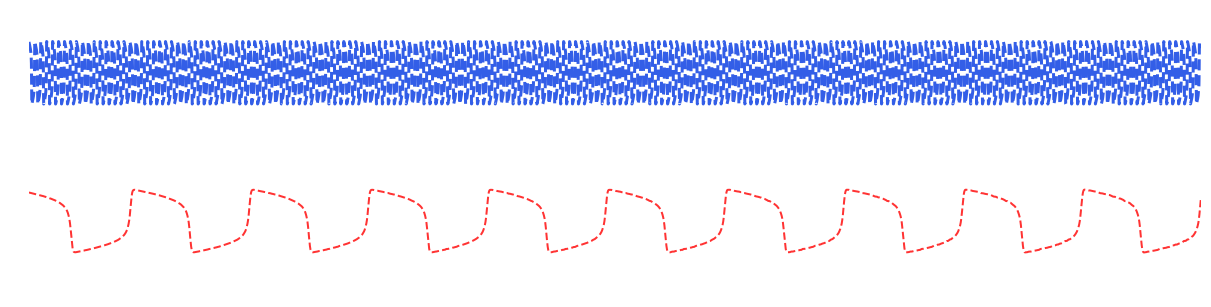

In [11]:
T_display = 10*slow_period_length

plt.figure(figsize=(21,5))

plt.subplot(2,1,1)
plt.plot(t_simulate, dmd_reconstruction_fast[0], '--', alpha=0.8, linewidth=3, color='#0036E2')
plt.xlim([0,T_display])
plt.ylim([-4,4])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(t_simulate, dmd_reconstruction_slow[0], 'r--', alpha=0.8, linewidth=2)
plt.xlim([0,T_display])
plt.ylim([-4,4])
plt.axis('off')